In [1]:
import cv2
import keras
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
#from scipy.misc import imread
from imageio import imread
import tensorflow as tf
import os

from ssd_model import SSD512
from ssd_utils import PriorUtil

Using TensorFlow backend.


In [2]:
input_shape = (512, 512, 3)
batch_size = 32

image_size = input_shape[:2]
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2007/')
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.8)
num_classes = gt_util.num_classes

model = SSD512(input_shape, num_classes=num_classes)
prior_util = PriorUtil(model)

model.load_weights('./models/ssd512_voc_weights_fixed.hdf5', by_name=True)

In [4]:
from utils.caffe2keras import compare_output_shape
compare_output_shape(model, './models/ssd512_voc_shape.pkl')

conv1_1                        [64, 512, 512]       [512, 512, 64]       
conv1_2                        [64, 512, 512]       [512, 512, 64]       
pool1                          [64, 256, 256]       [256, 256, 64]       
conv2_1                        [128, 256, 256]      [256, 256, 128]      
conv2_2                        [128, 256, 256]      [256, 256, 128]      
pool2                          [128, 128, 128]      [128, 128, 128]      
conv3_1                        [256, 128, 128]      [128, 128, 256]      
conv3_2                        [256, 128, 128]      [128, 128, 256]      
conv3_3                        [256, 128, 128]      [128, 128, 256]      
pool3                          [256, 64, 64]        [64, 64, 256]        
conv4_1                        [512, 64, 64]        [64, 64, 512]        
conv4_2                        [512, 64, 64]        [64, 64, 512]        
conv4_3                        [512, 64, 64]        [64, 64, 512]        
pool4                          [512, 3

In [5]:
from ssd_data import preprocess_image
po = np.get_printoptions()
np.set_printoptions(formatter={'all': '{:+.6e}'.format})

for layer in model.layers:
    layer_name = layer.name
    
    n = 12; p = 5

    file_name = os.path.join('ssd512_voc_activations_fish-bike', layer_name+'.npy')
    try:
        caffe_output = np.load(file_name)
    except FileNotFoundError:
        print(layer_name)
        continue
        
    if len(caffe_output.shape) == 4:
        caffe_output = caffe_output.transpose(0,2,3,1)

    input_image = np.round(preprocess_image('pics/fish-bike.jpg', (512,512)), 4)
    f = K.function(model.inputs, [model.get_layer(layer_name).output])
    keras_output = f([[input_image]])[0]
    
    try:
        diff = np.round(caffe_output[0]-keras_output[0], 9)
    except ValueError:
        print(" %s %s" % (caffe_output.shape, keras_output.shape))
        print(layer_name)
        continue
    
    min_diff = np.min(diff)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    max_abs_diff = np.max(np.abs(diff))
    diff_ratio = np.nonzero(np.round(diff,4))[0].shape[0] / np.prod(diff.shape)
    
    print('%-28s %10.6f %10.6f  %3i%%' % (layer_name, mean_diff, max_abs_diff, diff_ratio*100))

np.set_printoptions(**po)
img_path = './data/images/fish-bike.jpg'

img = preprocess_image(img_path, size=image_size, lib='skimage')

print(img.transpose((2, 0, 1))[:,:5,:5])

input_1
conv1_1
conv1_2
pool1
conv2_1
conv2_2
pool2
conv3_1
conv3_2
conv3_3
pool3
conv4_1
conv4_2
conv4_3
pool4
conv5_1
conv5_2
conv5_3
pool5
fc6
fc7
conv6_1
conv6_2
conv7_1
conv7_2
conv8_1
conv8_2
conv9_1
conv9_2
conv10_1
conv4_3_norm
conv10_2
conv4_3_norm_mbox_conf
fc7_mbox_conf
conv6_2_mbox_conf
conv7_2_mbox_conf
conv8_2_mbox_conf
conv9_2_mbox_conf
conv10_2_mbox_conf
conv4_3_norm_mbox_loc
fc7_mbox_loc
conv6_2_mbox_loc
conv7_2_mbox_loc
conv8_2_mbox_loc
conv9_2_mbox_loc
conv10_2_mbox_loc
conv4_3_norm_mbox_conf_flat
fc7_mbox_conf_flat
conv6_2_mbox_conf_flat
conv7_2_mbox_conf_flat
conv8_2_mbox_conf_flat
conv9_2_mbox_conf_flat
conv10_2_mbox_conf_flat
conv4_3_norm_mbox_loc_flat
fc7_mbox_loc_flat
conv6_2_mbox_loc_flat
conv7_2_mbox_loc_flat
conv8_2_mbox_loc_flat
conv9_2_mbox_loc_flat
conv10_2_mbox_loc_flat
mbox_conf
mbox_loc
mbox_conf_logits
mbox_loc_final
mbox_conf_final
predictions
[[[-40.740494   -37.282875   -34.36676    -26.80413    -30.24263   ]
  [-17.333527   -16.461388   -14.007469

In [16]:
inputs = []
images = []
for img_path in ['./data/images/fish-bike.jpg',
                 './data/images/cat.jpg',
                 './data/images/boys.jpg',
                 './data/images/car_cat.jpg',
                 './data/images/car_cat2.jpg',
                ]:
    images.append(imread(img_path))
    inputs.append(preprocess_image(img_path, image_size))

inputs = np.array(inputs)

In [20]:
preds = model.predict(inputs, batch_size=1, verbose=1)

results = [prior_util.decode(p) for p in preds]

5/5 [==============================] - 0s 27ms/step


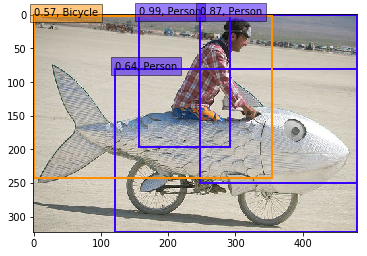

[[ 0.32576913  0.          0.60566385  0.60846117  0.99035978 15.        ]
 [ 0.51347728  0.          1.          0.77319937  0.86698967 15.        ]
 [ 0.25105869  0.25083642  1.          1.          0.64433998 15.        ]
 ...
 [ 0.75996666  0.          1.          0.11296783  0.02257502  1.        ]
 [ 0.47727379  0.40722293  1.          0.82959997  0.02247155 11.        ]
 [ 0.88205355  0.          1.          0.2269821   0.02219578  1.        ]]


In [38]:
plt.figure()
plt.imshow(images[0])
res = prior_util.decode(preds[0])
prior_util.plot_results(classes=gt_util.classes, confidence_threshold=0.5) # 0.1 !!!
plt.show()
print(res)

In [43]:
# layer activation
po = np.get_printoptions()
#np.set_printoptions(formatter={'all': '{:+.6e}'.format})
np.set_printoptions(formatter={'all': '{:+.8f}'.format})

print('%-28s %14s %10s %10s  %4s' % ('', 'max activation', 'mean diff', 'max diff', 'ratio'))

for layer in model.layers:
    layer_name = layer.name
    
    file_name = os.path.join('./caffe_activation_dumps/ssd512_voc_activations_fish-bike', layer_name+'.npy')
    try:
        caffe_output = np.load(file_name)
    except FileNotFoundError:
        print(layer_name)
        continue
        
    if len(caffe_output.shape) == 4:
        caffe_output = caffe_output.transpose(0,2,3,1)

    input_image = preprocess_image('./data/images/fish-bike.jpg', input_shape[:2])
    f = K.function(model.inputs, [model.get_layer(layer_name).output])
    keras_output = f([[input_image]])[0]

    try:
        diff = np.round(caffe_output[0]-keras_output[0], 9)
    except ValueError:
        print(layer_name)
        continue
    
    max_value = np.max(keras_output)
    min_diff = np.abs(np.min(diff))
    max_diff = np.abs(np.max(diff))
    mean_diff = np.abs(np.mean(diff))
    
    diff_ratio = np.nonzero(np.round(diff,5))[0].shape[0] / np.prod(diff.shape)
    
    print('%-28s %14.6f %10.6f %10.6f  %3i%%' % (layer_name, max_value, mean_diff, max_diff, diff_ratio*100))
    
    n = 12; p = 5
    #print(np.round( diff[:n,:n,p], 8))

np.set_printoptions(po)

                             max activation  mean diff   max diff  ratio
input_1
conv1_1                          518.164124   0.000000   0.000031    0%
conv1_2                         1872.668335   0.000000   0.001343   35%
pool1                           1872.668335   0.000000   0.001343   43%
conv2_1                         2972.968994   0.000000   0.002686   54%
conv2_2                         4747.130371   0.000000   0.004883   33%
pool2                           4747.130371   0.000000   0.004883   52%
conv3_1                         3989.785156   0.000000   0.003662   37%
conv3_2                         3428.608643   0.000001   0.003174   36%
conv3_3                         3365.445068   0.000000   0.003418   14%
pool3                           3365.445068   0.000000   0.003418   24%
conv4_1                         2772.205322   0.000000   0.001953   21%
conv4_2                          787.670471   0.000000   0.000854   16%
conv4_3                          559.113831   0.000000 

In [44]:
fstr = '%-28s %-20s %-20s %-12s %-9s %-9s %-28s %-22s %-8s %-8s %-8s'
print(fstr % ('', 'input_shape', 'output_shape', 'img_size', 'min_size', 'max_size', 'aspect_ratios', 'variances', 'clip', 'flip', 'step'))
for l in model.layers:
    if l.__class__.__name__ == 'PriorBox':
        aspect_ratios = [ round(e, 2) for e in l.aspect_ratios ]
        print(fstr % (l.name, l.input_shape, l.output_shape, l.img_size, l.min_size, l.max_size, aspect_ratios, l.variances, l.clip, l.flip, l.step))

                             input_shape          output_shape         img_size     min_size  max_size  aspect_ratios                variances              clip     flip     step    


In [ ]:
from utils.vis import plot_priorboxes
from ssd_utils import calc_priorboxes
        
img_path = 'pics/fish-bike.jpg'
image = imread(img_path)
input_image = preprocess_image(img_path)

for layer in model.layers:
    if layer.__class__.__name__ == 'PriorBox':
        prior_boxes = calc_priorboxes(model, layer.name)
        nratios = len(layer.aspect_ratios)
        nlocs = len(prior_boxes)/nratios
        print('%-28s  locations: %-6i  aspect_ratios: %s' % (layer.name, nlocs, layer.aspect_ratios))
        plot_priorboxes(prior_boxes, image, nratios)

#np.save('ssd512_prior_boxes.npy', calc_priorboxes(model))
#pb = np.load('ssd512_prior_boxes.npy')

In [ ]:
# compare the prior boxes

mbox_priorbox = model.get_layer('mbox_priorbox')
f = K.function(model.inputs, [mbox_priorbox.output])
pb_keras = f([[input_image]])[0][0][:,:4]

pb_caffe = np.load('ssd512_prior_boxes_caffe.npy')

print(pb_keras[:10])
print(np.array([np.min(pb_keras, 0), np.max(pb_keras, 0), np.mean(pb_keras, 0)]))
print()
print(pb_caffe[:10])
print(np.array([np.min(pb_caffe, 0), np.max(pb_caffe, 0), np.mean(pb_caffe, 0)]))
print()
pb_diff = pb_keras - pb_caffe
print(pb_diff[:10])
print(np.mean(pb_diff, 0))
print(np.nonzero(np.round(pb_diff, 6))[0])

In [ ]:
# compare the positions

pos_keras = np.array([pb_keras[:,0]+pb_keras[:,2], pb_keras[:,1]+pb_keras[:,3]]).T/2
pos_caffe = np.array([pb_caffe[:,0]+pb_caffe[:,2], pb_caffe[:,1]+pb_caffe[:,3]]).T/2
pos_diff = pos_keras - pos_caffe

print(np.array([np.min(pos_keras, 0), np.max(pos_keras, 0), np.mean(pos_keras, 0)]))
print()
print(np.array([np.min(pos_caffe, 0), np.max(pos_caffe, 0), np.mean(pos_caffe, 0)]))
print()
print(pos_diff[:20])
print(np.nonzero(np.round(pos_diff, 6))[0])

In [ ]:
# compute positions

steps = [8, 16, 32, 64, 128, 256, 512]
img_width, img_height = 512, 512
layer_sizes = (64, 32, 16, 8, 4, 2, 1)
aspect_ratios = ([1.0, 1.0, 2, 0.5], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5], [1.0, 1.0, 2, 0.5])

idx = 0
for i in range(len(layer_sizes)):
    nboxes = len(aspect_ratios[i]) * layer_sizes[i]**2
    print("%i  %s  %i" % (layer_sizes[i], aspect_ratios[i], nboxes))
    print(np.max(pos_keras[idx:idx+nboxes,0]))
    print(np.max(pos_caffe[idx:idx+nboxes,0]))
    #print(np.min(pos_keras[idx:idx+nboxes,0]))
    #print(np.min(pos_caffe[idx:idx+nboxes,0]))
    
    layer_width = layer_sizes[i]
    
    # keras way
    step_x = img_width / layer_width
    centers_x = np.linspace(step_x / 2., img_width - step_x / 2., layer_width) / img_width
    #centers_x = np.array([(0.5 + i) for i in range(layer_width)]) * step_x / img_width
    print('%-20s %-20s' % (np.max(centers_x), step_x))
    
    # caffe way
    step_x = steps[i]
    centers_x = np.array([(0.5 + i) for i in range(layer_width)]) * step_x / img_width
    print('%-20s %-20s' % (np.max(centers_x), step_x))
    
    print()
    idx += nboxes

In [ ]:
#calucalation of min and max_size

min_dim = 512
# conv4_3 ==> 64 x 64
# fc7 ==> 32 x 32
# conv6_2 ==> 16 x 16
# conv7_2 ==> 8 x 8
# conv8_2 ==> 4 x 4
# conv9_2 ==> 2 x 2
# conv10_2 ==> 1 x 1
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2', 'conv10_2']
# in percent %
min_ratio = 15
max_ratio = 90
step = int(np.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

print(min_sizes)
print(max_sizes)

In [17]:
np.set_printoptions(precision=4)
import math

# calculation of min_sizes / max_sizes values
# and why float in prototext and cat to int in PriorBox layer, confusing

In [20]:
min_dim = 512
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2', 'conv10_2']
min_ratio = 15
max_ratio = 90
n = len(mbox_source_layers)

step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes
print(min_sizes)
print(max_sizes)

[35.84, 76.8, 153.6, 230.4, 307.2, 384.0, 460.8]
[76.8, 153.6, 230.4, 307.2, 384.0, 460.8, 537.6]


In [6]:
# naiv approach according to the paper
np.linspace(min_ratio, max_ratio, n+1) * min_dim / 100.

array([  76.8   ,  131.6571,  186.5143,  241.3714,  296.2286,  351.0857,  405.9429,  460.8   ])

In [14]:
# why is it done in the following way?
a = np.linspace(min_ratio, max_ratio, n-1)
a = np.concatenate((np.array([7]), a ,np.array([a[-1]+min_ratio])))
a * min_dim / 100.

array([  35.84,   76.8 ,  153.6 ,  230.4 ,  307.2 ,  384.  ,  460.8 ,  537.6 ])

In [8]:
# as in pytb
import numpy as np
np.set_printoptions(precision=1)

s_min = 0.15
s_max = 0.90
m = 8
s = []
for k in range(1,m+1):
    s_k = s_min + (s_max - s_min) * (k - 1.0) / (m - 1.0) # equation 2
    s.append(s_k)
np.array(s) * 512

array([  76.8,  131.7,  186.5,  241.4,  296.2,  351.1,  405.9,  460.8])

In [ ]:
# compute prior box sizes

steps = [8, 16, 32, 64, 128, 256, 512]
img_width, img_height = 512, 512
layer_sizes = (64, 32, 16, 8, 4, 2, 1)
aspect_ratios = ([1.0, 1.0, 2, 0.5], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5, 3, 0.3333333333333333], [1.0, 1.0, 2, 0.5], [1.0, 1.0, 2, 0.5])

nboxes = []
unique_size_values_keras = []
for i in range(len(layer_sizes)):
    layer_width = layer_height = layer_sizes[i]
    nboxes.append( layer_width * layer_height * len(aspect_ratios[i]) )
    min_size = int(min_sizes[i])
    max_size = int(max_sizes[i])
    box_widths = []
    box_heights = []
    for ar in aspect_ratios[i]:
        if ar == 1 and len(box_widths) > 0:
            box_widths.append(np.sqrt(min_size * max_size))
            box_heights.append(np.sqrt(min_size * max_size))
        else:
            box_widths.append(min_size * np.sqrt(ar))
            box_heights.append(min_size / np.sqrt(ar))
    #print(aspect_ratios[i])
    #print(np.array(box_widths)/img_width)
    #print(np.array(box_heights)/img_height)
    values = np.unique(np.round(np.array(box_widths)/img_width, 4))
    print(values)
    unique_size_values_keras.append(values)
    #print()
unique_size_values_keras = np.array(unique_size_values_keras)
print()

# caffe prior box sizes
size_caffe = np.array([pb_caffe[:,2]-pb_caffe[:,0], pb_caffe[:,3]-pb_caffe[:,1]]).T
offset = 0
unique_size_values_caffe = []
for n in nboxes:
    values = np.unique(np.round(size_caffe[offset:offset+n],4))
    print(values)
    unique_size_values_caffe.append(values)
    offset += n
unique_size_values_caffe = np.array(unique_size_values_caffe)
print()

for i in range(len(nboxes)):
    try:
        print(unique_size_values_caffe[i] - unique_size_values_keras[i])
    except:
        pass

In [6]:
fstr = '%-28s %-20s %-20s %-12s %-9s %-9s %-28s %-22s %-8s %-8s %-8s'
print(fstr % ('', 'input_shape', 'output_shape', 'img_size', 'min_size', 'max_size', 'aspect_ratios', 'variances', 'clip', 'flip', 'step'))
for l in model.layers:
    if l.__class__.__name__ == 'PriorBox':
        aspect_ratios = [ round(r, 2) for r in l.aspect_ratios ]
        print(fstr % (l.name, l.input_shape, l.output_shape, l.img_size, l.min_size, l.max_size, aspect_ratios, l.variances, l.clip, l.flip, l.step))

                             input_shape          output_shape         img_size     min_size  max_size  aspect_ratios                variances              clip     flip     step    
conv4_3_norm_mbox_priorbox   (None, 64, 64, 512)  (None, 16384, 8)     (512, 512)   35        76        [1.0, 1.0, 2, 0.5]           [ 0.1  0.1  0.2  0.2]  False    True     None    
fc7_mbox_priorbox            (None, 32, 32, 1024) (None, 6144, 8)      (512, 512)   76        153       [1.0, 1.0, 2, 0.5, 3, 0.33]  [ 0.1  0.1  0.2  0.2]  False    True     None    
conv6_2_mbox_priorbox        (None, 16, 16, 512)  (None, 1536, 8)      (512, 512)   153       230       [1.0, 1.0, 2, 0.5, 3, 0.33]  [ 0.1  0.1  0.2  0.2]  False    True     None    
conv7_2_mbox_priorbox        (None, 8, 8, 256)    (None, 384, 8)       (512, 512)   230       307       [1.0, 1.0, 2, 0.5, 3, 0.33]  [ 0.1  0.1  0.2  0.2]  False    True     None    
conv8_2_mbox_priorbox        (None, 4, 4, 256)    (None, 96, 8)        (512, 512)   3

In [20]:

layer_widths = [64, 32, 16, 8, 4, 2, 1]

layer_widths = []
for l in model.layers:
    if l.__class__.__name__ == 'PriorBox':
        layer_widths.append(l.input_shape[1])

gamma = 1.5
image_width = image_size[0]
a = image_width / np.array(layer_widths) * gamma


12.0